# **💁🏻🗨️💁🏻‍♂️안개 예측 EDA code**
> **안개량 예측** 경진대회에 오신 여러분 환영합니다! 🎉    
> 본 대회에서는 최대 10명이 참여할 수 있는 기상청 주관 날씨 빅데이터 경진대회 입니다.     
> 주어진 데이터를 활용하여 안개 상태의 구간을 예측할 수 있는 모델을 만드는 것이 목표입니다!

# Contents  
  
- 필요한 라이브러리 설치  
- 데이터 불러오기  
- 사용할 변수 선택하기
- 모델링
- 추론
- 결과 저장하기
- 결과 그 이후

### 1. 필요한 라이브러리 설치

- 필요한 라이브러리를 설치한 후 불러옵니다.

In [149]:
# basic
import os, random
import pandas as pd
import numpy as np
import torch

# model
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

# eval metric
from sklearn.metrics import confusion_matrix

# k-fold by timeseries split
from sklearn.model_selection import TimeSeriesSplit

# graph
import shap
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

In [150]:
# random seed 고정하기
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

### 2. 데이터 불러오기
- 제공된 데이터를 불러옵니다.

> - year : 년도
> - month : 월
> - day : 일
> - hour : 시간
> - minute : 분(10분 단위)
> - stn_id : 지점 번호
> - ws10_deg : 10분 평균 풍향, deg
> - ws10_ms : 10분 평균 풍속, m/s
> - ta : 1분 평균 기온 10분 주기, 섭씨
> - re : 강수 유무 0:무강수, 1:강수
> - hm : 1분 평균 상대 습도 10분 주기, %
> - sun10 : 1분 일사량 10분 단위 합계, MJ
> - ts : 1분 평균 지면온도 10분 주기, 섭씨

- test 없는 데이터 값
> - vis1 : 1분 평균 시정 10분 주기, m
> - class : 시정 구간

시정 구간은 다음과 같다.
- 0초과 200미만 : 1
- 200이상 500미만 : 2
- 500이상 1000미만 : 3
- 1000이상 : 4
- 4번은 맞춰도 스코어가 증가하진 않지만 틀리면 감점

In [151]:
# load makes data
train = pd.read_csv('../data/train_preprocessed_data.csv')
test = pd.read_csv('../data/test_preprocessed_data.csv')

### 3. 사용할 변수 선택하기

데이터에서 필요한 칼럼을 선택하여 적용하기로 한다.

In [152]:
# onehotencoder in ground
# train['A'] = np.where(train['ground'] == 'A', 1, 0)
# train['B'] = np.where(train['ground'] == 'B', 1, 0)
# train['C'] = np.where(train['ground'] == 'C', 1, 0)
# train['D'] = np.where(train['ground'] == 'D', 1, 0)

# test['A'] = np.where(test['ground'] == 'A', 1, 0)
# test['B'] = np.where(test['ground'] == 'B', 1, 0)
# test['C'] = np.where(test['ground'] == 'C', 1, 0)
# test['D'] = np.where(test['ground'] == 'D', 1, 0)

#### 단순히 I, J년 train, K년 valid로 활용할 때 사용할 코드

In [153]:
# label 선택하기
use_label_x = ['hm', 're', 'sun10', 'ta', 'ts', 'ws10_deg', 'ws10_ms', 'ground', # 'A', 'B', 'C', 'D',
       'dew_point', 'sin_time', 'cos_time', 'sin_month', 'cos_month', 'diff_air-dew', 'diff_ts-dew', 'make_copyfog',
       'make_irufog', 'make_mountfog', 'make_gimfog', 'retain_fog', 'upclass_fog'
       ]

use_label_y = ['class']

In [154]:
# train_x, train_y, test_x 만들자
# train: I,J년도, valid: K년도, test: L년도
# train_x = train.loc[(train['year'].isin(['I', 'J'])), use_label_x]
# train_y = train.loc[(train['year'].isin(['I', 'J'])), use_label_y]

# valid_x = train.loc[train['year'].isin(['K']), use_label_x]
# valid_y = train.loc[train['year'].isin(['K']), use_label_y]

# test_x = test[use_label_x]

#### TimeSeriesSplit

In [155]:
# 지정 label
use_label = [
    'hm', 're', 'sun10', 'ta', 'ts', 'ws10_deg', 'ws10_ms', 'ground', # 'A', 'B', 'C', 'D',
    'dew_point', 'sin_time', 'cos_time', 'sin_month', 'cos_month', 'diff_air-dew', 'diff_ts-dew', 
    # 'make_copyfog', 'make_irufog', 'make_mountfog', 'make_gimfog', 'retain_fog', 'upclass_fog',
    'class'
]

cat_features = [
    're', 'ground' #, # 'A', 'B', 'C', 'D',
    # 'make_copyfog', 'make_irufog', 'make_mountfog', 'make_gimfog', 'retain_fog', 'upclass_fog'
]

In [156]:
# 사용할 변수만 넣어주기
use_train = train[use_label]
use_test = test[use_label]

In [157]:
# parameter 지정
# gap: train 이후 몇개를 사용하지 않을것인지 정하기 위한 파라미터
tscv = TimeSeriesSplit(n_splits = 6)

In [158]:
# train_x, train_y, test_x 만들자
train_x = use_train[use_train.columns.difference(['class'])]
train_y = use_train['class']

test_x = test[use_train.columns.difference(['class'])]

In [159]:
# str
train_y = train_y.astype(str)

### 4. 모델링
Catboost는 시계열 데이터 또는 범주형 데이터에 좋은 성능을 가져오는 모델로 알려져 있기 때문에 적용하도록 한다.

timeseries split을 활용해 적합을 진행해보도록 한다.

In [160]:
# custom metric
class CSIMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        best_class = np.zeros(len(approxes[0]))
        
        for i in range(len(approxes[0])):
            approx_i = [approxes[j][i] for j in range(len(approxes))]
            best_class[i] = np.argmax(np.array(approx_i))
        
        accuracy_sum = 0
        weight_sum = 0 

        for i in range(len(target)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            if best_class[i] != '4' or best_class[i] != 4:
                accuracy_sum += w * (best_class[i] == target[i])

        return accuracy_sum, weight_sum

In [161]:
# time series cv fitting models

# 해당 스코어와 모델 저장 리스트
scores = []
models = []

# split마다 모델 적합하기
for train_idx, valid_idx in tscv.split(use_train):
    print("="*50)
    
    # 가중치 만들기
    class_weights = [100, 65, 64, 0.25]

    # 파라미터 구성
    cb = CatBoostClassifier(
            cat_features = cat_features,
            one_hot_max_size = 4,
            eval_metric = CSIMetric(),
            class_weights = class_weights,
            random_state = 42
        )

    # fit the model
    cb.fit(
        train_x.iloc[train_idx], train_y[train_idx],
        eval_set = [(train_x.iloc[valid_idx], train_y[valid_idx])],
        early_stopping_rounds = 50,
        verbose = 100
    )

    # 모델 결과 저장하기
    models.append(cb)
    scores.append(cb.get_best_score()['validation']['CSIMetric'])

    # if is_holdout:
    #     break 


Learning rate set to 0.122014
0:	learn: 0.6672768	test: 0.3213302	best: 0.3213302 (0)	total: 1.96s	remaining: 32m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4015920865
bestIteration = 2

Shrink model to first 3 iterations.
Learning rate set to 0.123717
0:	learn: 0.5223559	test: 0.5412825	best: 0.5412825 (0)	total: 2.36s	remaining: 39m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5601200803
bestIteration = 2

Shrink model to first 3 iterations.
Learning rate set to 0.124725
0:	learn: 0.5316946	test: 0.4793063	best: 0.4793063 (0)	total: 3.14s	remaining: 52m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4821054087
bestIteration = 11

Shrink model to first 12 iterations.
Learning rate set to 0.125444
0:	learn: 0.5099853	test: 0.4699792	best: 0.4699792 (0)	total: 3.56s	remaining: 59m 21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5539996219
bestIteration = 11

Shrink model to first 12 

In [162]:
# cv 결과 확인
print(scores)
print(np.mean(scores))

[0.40159208652925277, 0.5601200802695185, 0.4821054086524852, 0.5539996218689717, 0.6012297900294917, 0.5804495410896808]
0.5299160880732334


In [163]:
# evaluation
def csi_score(CONFUSION_MATRIX, exceptcol = 0):

    # 차원의 수
    n, _ = CONFUSION_MATRIX.shape

    # 계산하여 받을 값
    H = 0
    F = 0
    M = 0
    for i in range(n):
        for j in range(n):
            if i == j == exceptcol:
                continue
            elif i == j:
                H += CONFUSION_MATRIX[i][j]
            elif j != exceptcol:
                F += CONFUSION_MATRIX[i][j]
            elif i != exceptcol:
                M += CONFUSION_MATRIX[i][j]

    return H / (H + F + M)

In [164]:
# csi_score(confusion_matrix(valid_y, cb_pred), 3)

### 5. 추론

- train, valid를 모두 포함한 데이터를 통해 전체적으로 학습을 다시 진행한 다음 test를 적합하도록 한다.  
- 이름을 꼭 ID에 맞도록 설정해 주어야 한다.

In [165]:
# predict
pred_list = []

# 각 모델별 예측값 가져오기
for i, model in enumerate(models):
    pred_list.append(model.predict_proba(test_x))

In [166]:
# 확률값 평균내기
pred_proba = np.mean(pred_list, axis = 0)

In [167]:
# 예측값 가져오기
pred_class = np.argmax(pred_proba, axis = 1) + 1

In [168]:
np.unique(pred_class, return_counts=True)

(array([1, 2, 3, 4], dtype=int64),
 array([ 15820,  12036,  19035, 215909], dtype=int64))

### 6. 제출물 저장하기

In [169]:
# 제출물 불러오기
submission = pd.read_csv('../Data/fog_test.csv')

In [170]:
# 앞에 필요없는 열 버리기
submission.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [171]:
# 대입해서 저장하기
submission['fog_test.class'] = pred_class

In [172]:
# 저장하기
submission.to_csv('../data/240253.csv', index = False)

### 7. 분석 그 이후

- 생성한 모델에서 어떤 변수가 가장 영향을 주는지 확인할 필요가 있다.

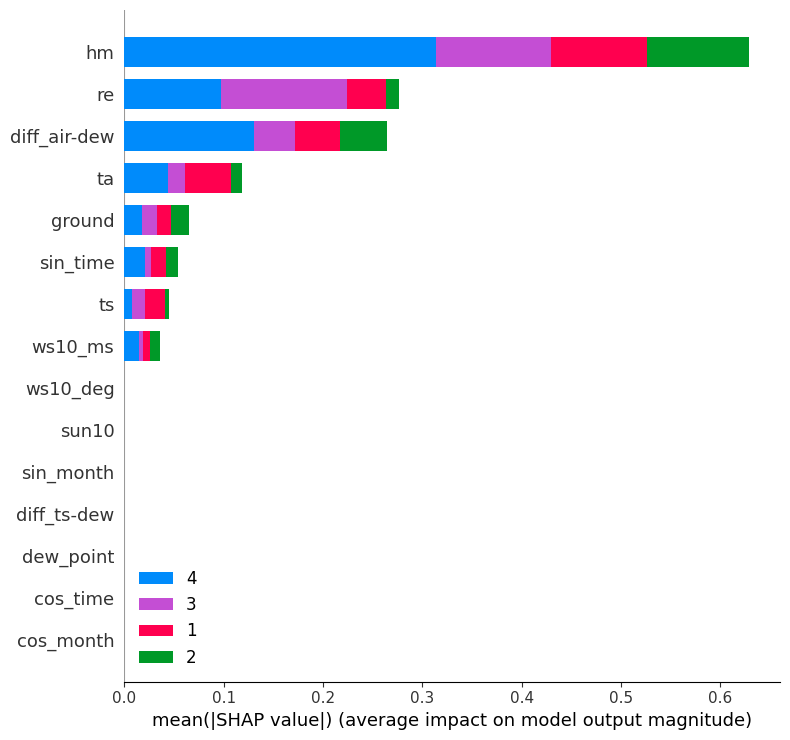

--------------------------------------------------------------------------------


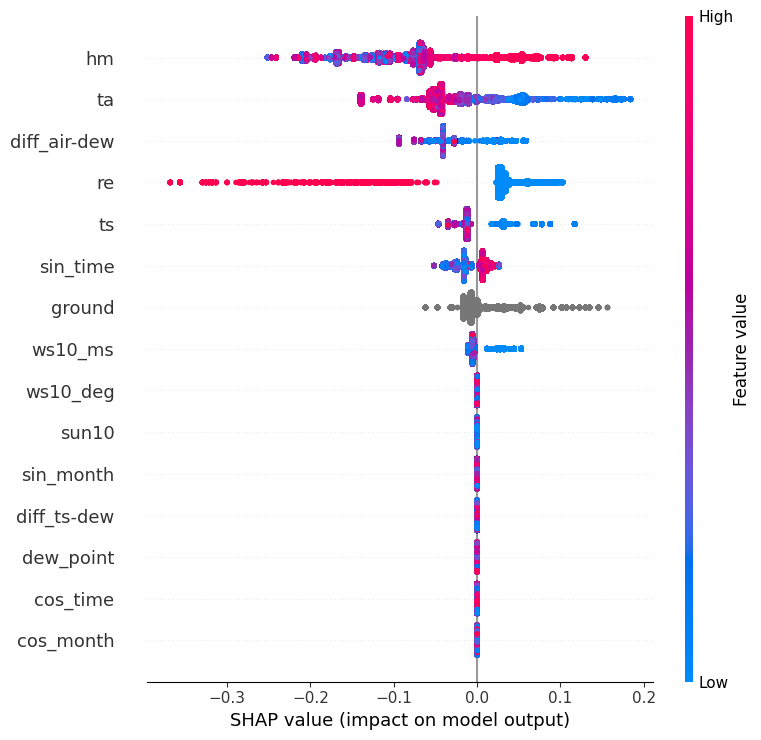

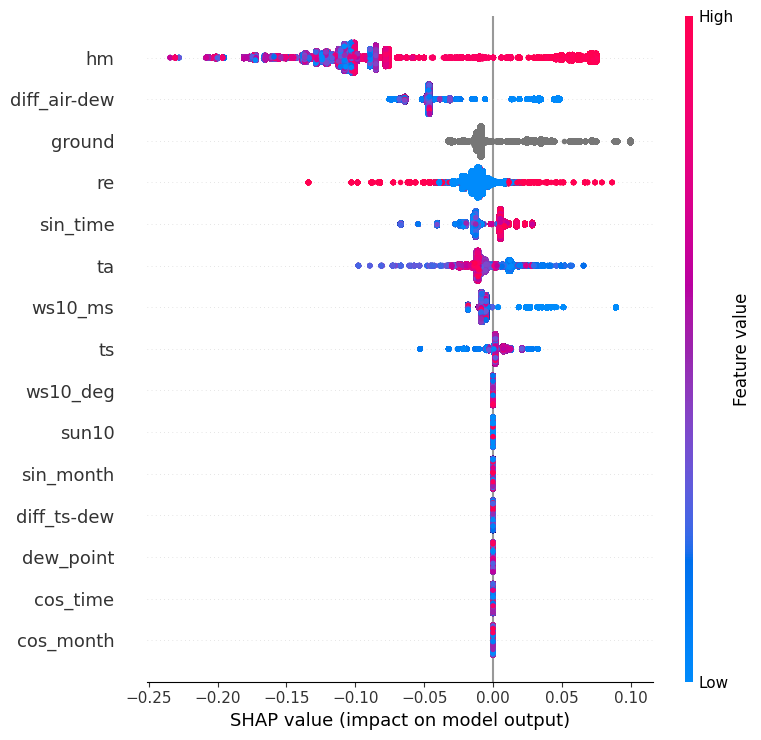

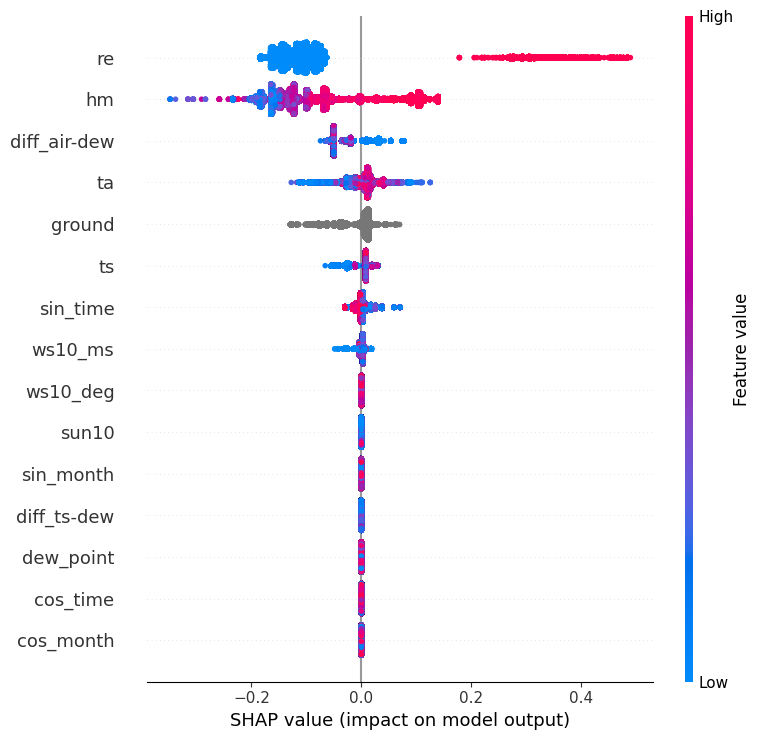

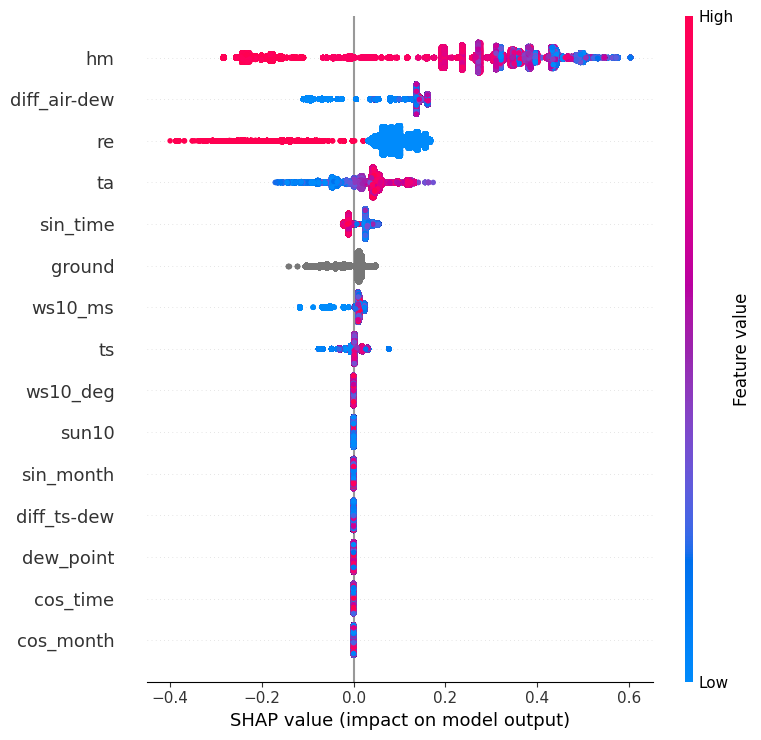

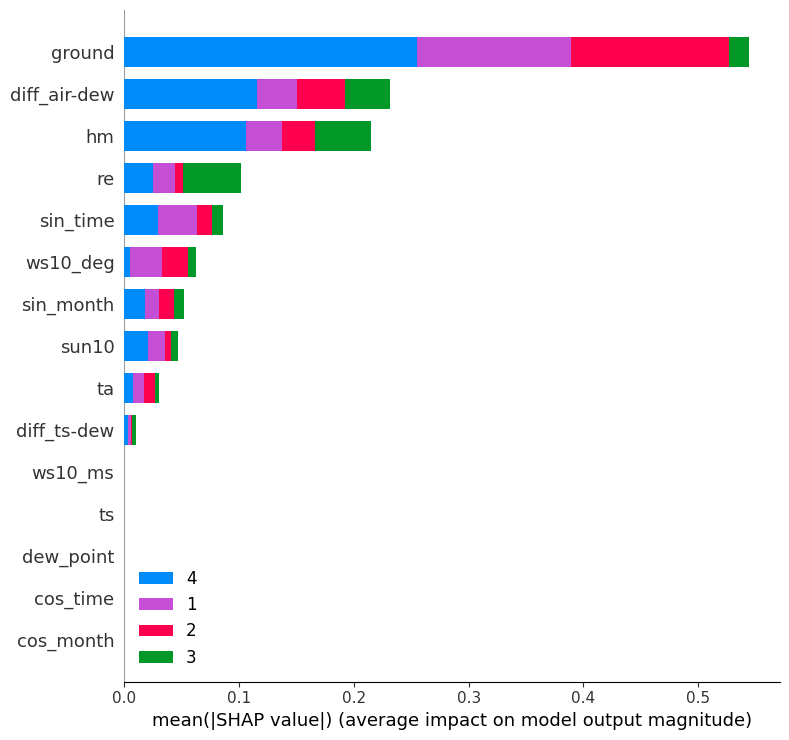

--------------------------------------------------------------------------------


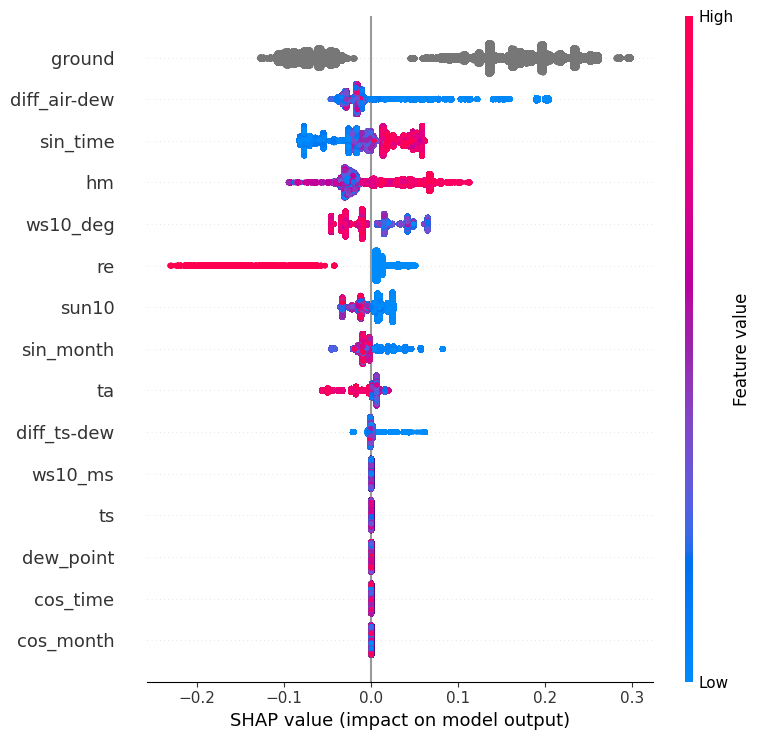

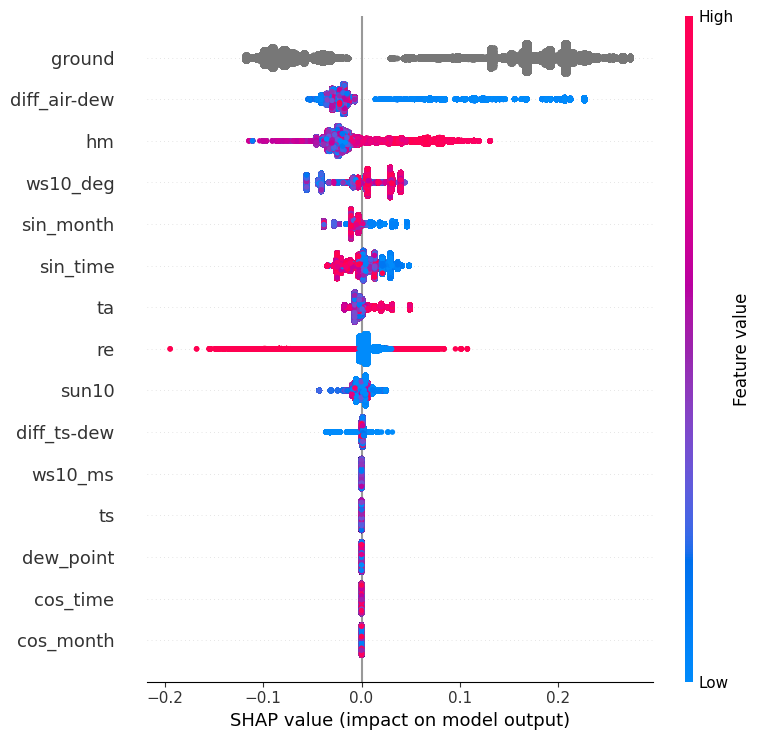

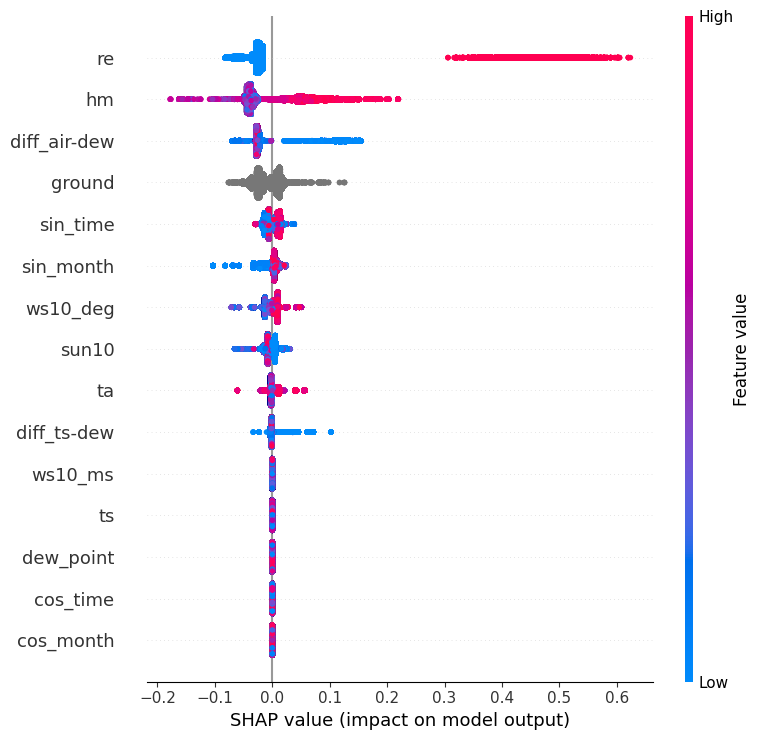

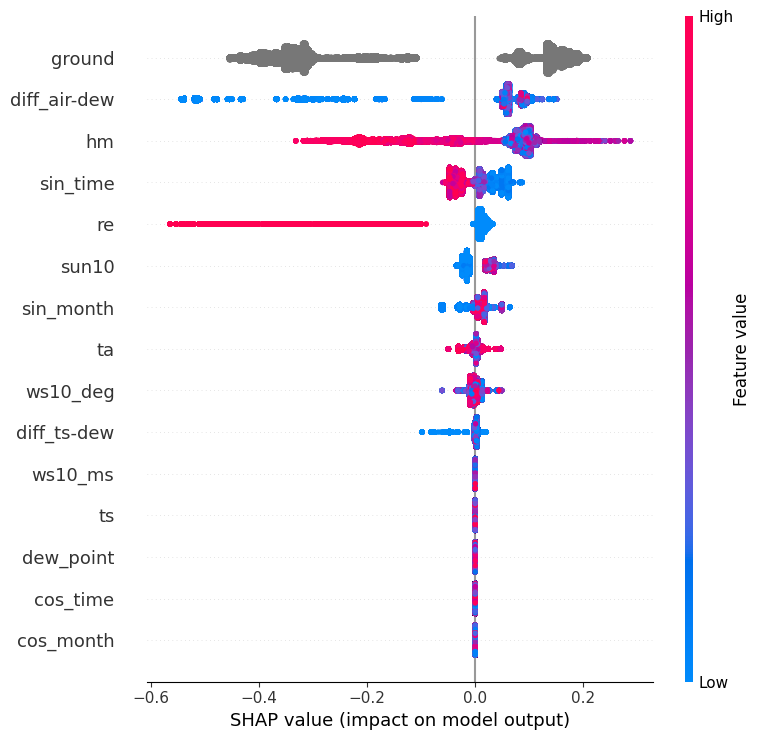

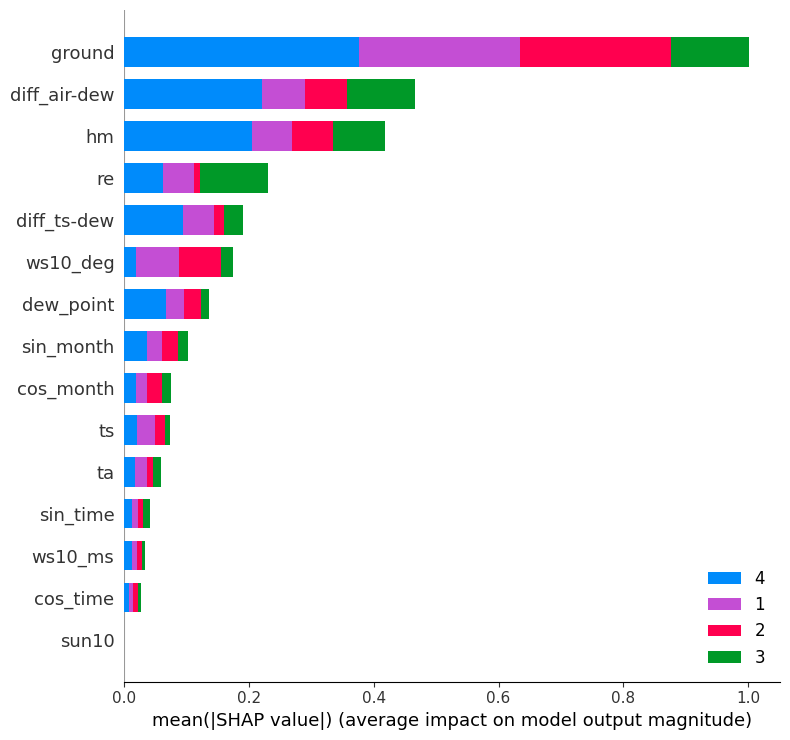

--------------------------------------------------------------------------------


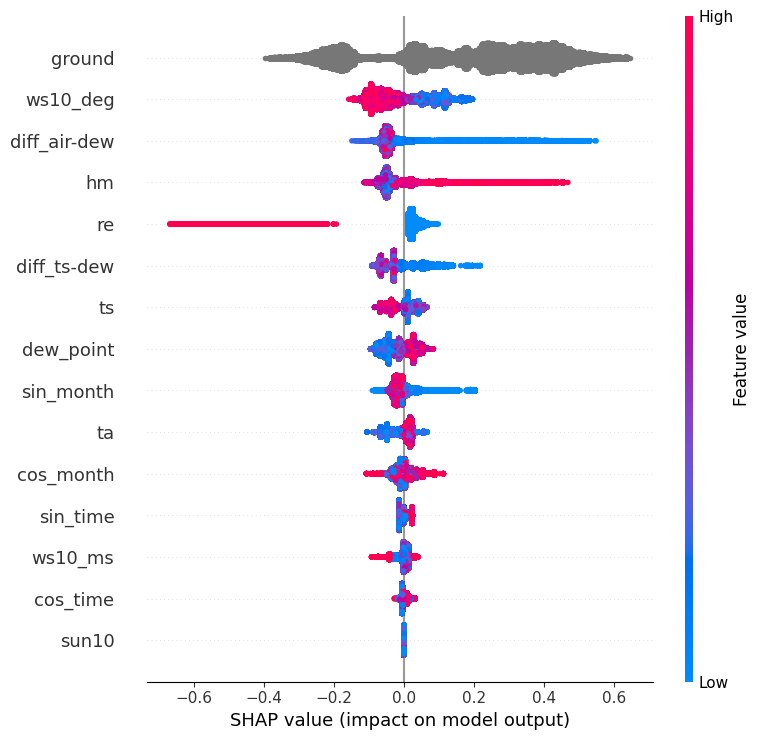

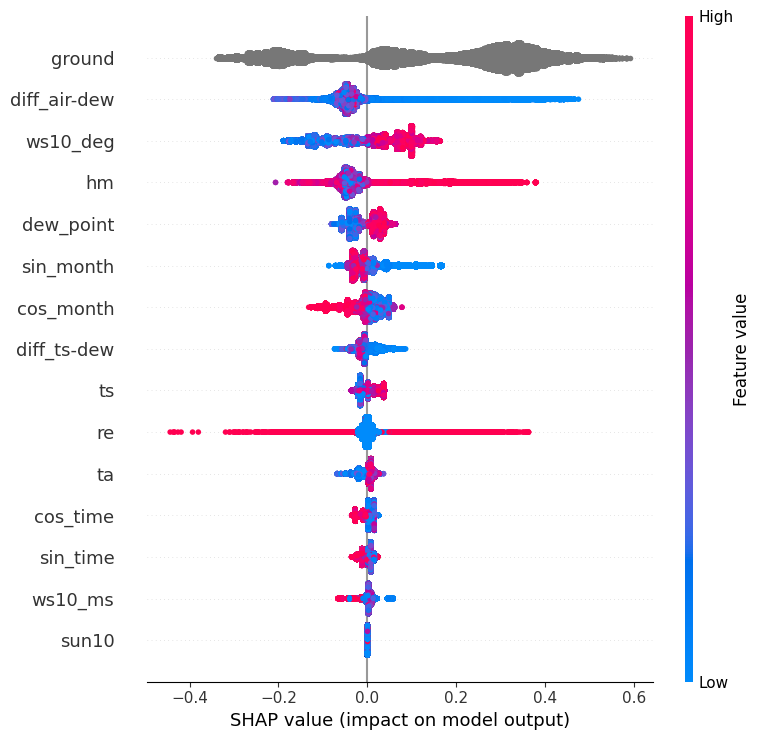

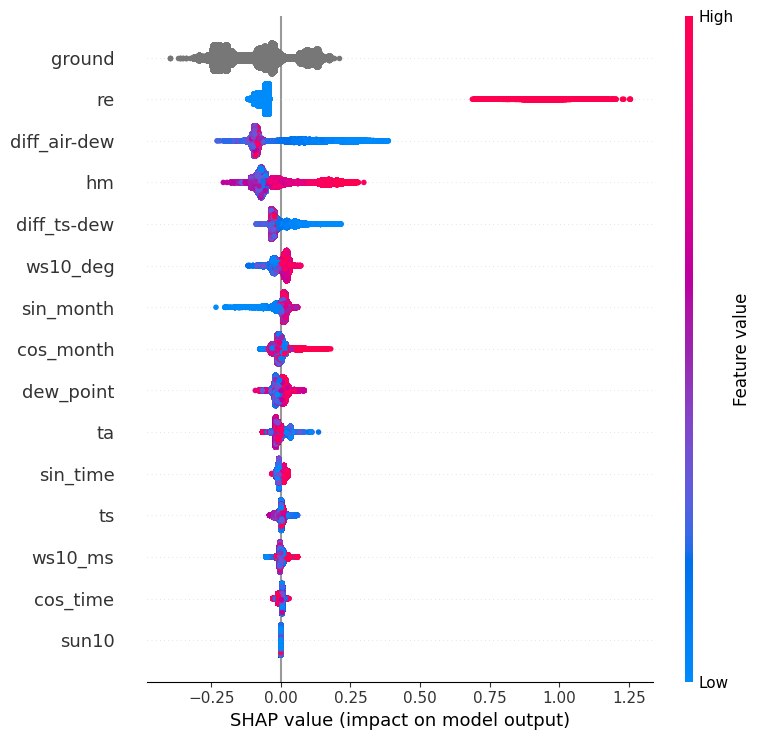

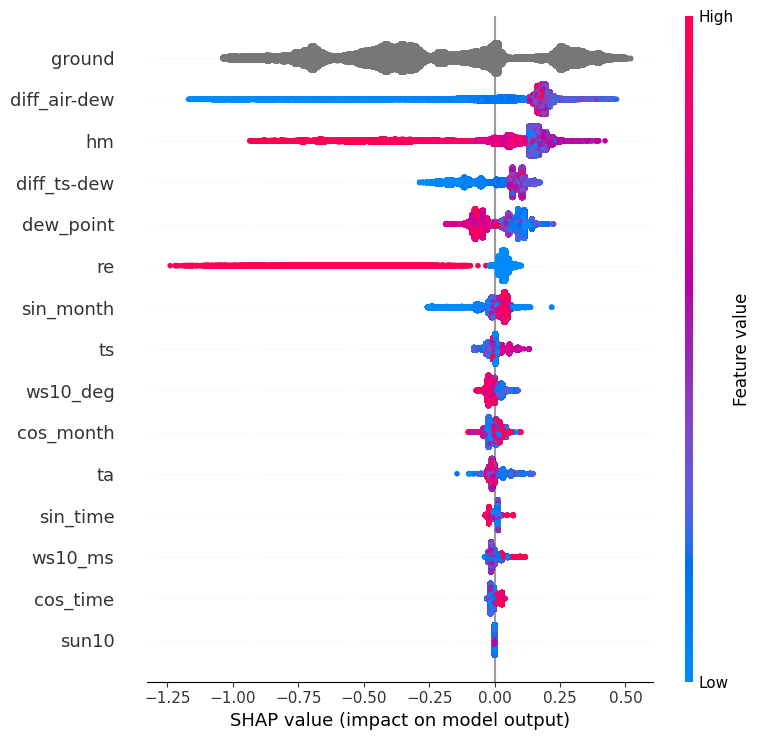

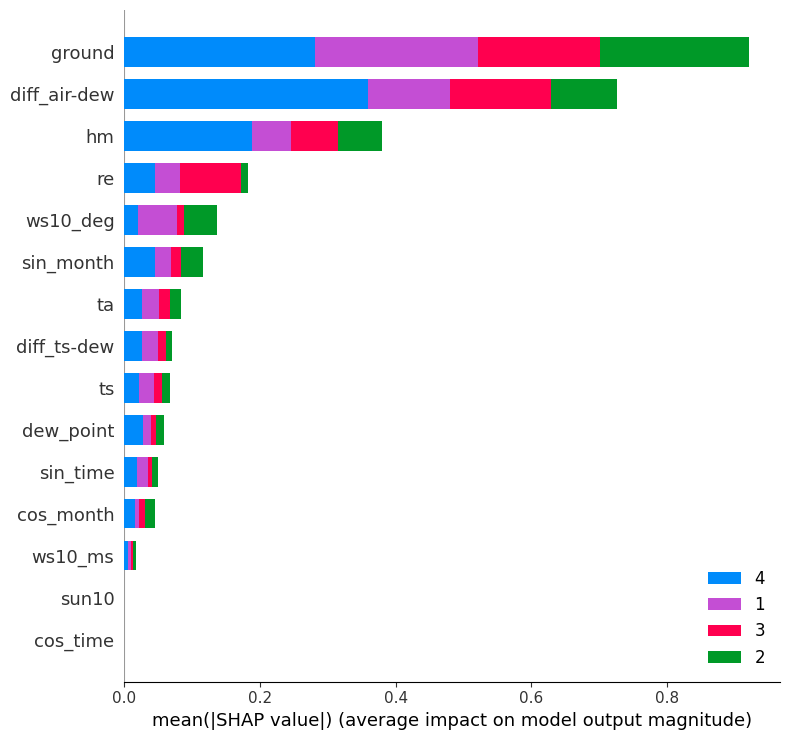

--------------------------------------------------------------------------------


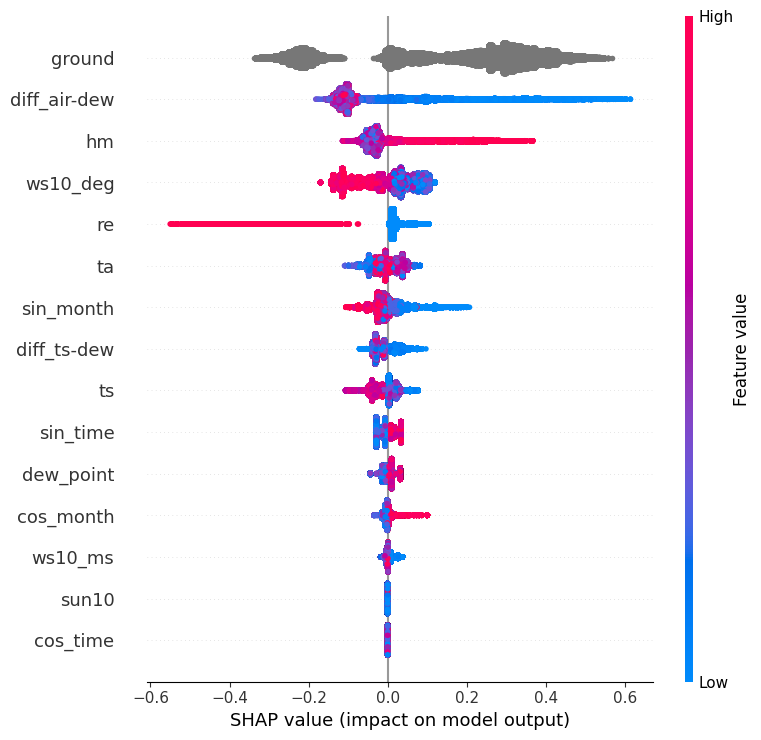

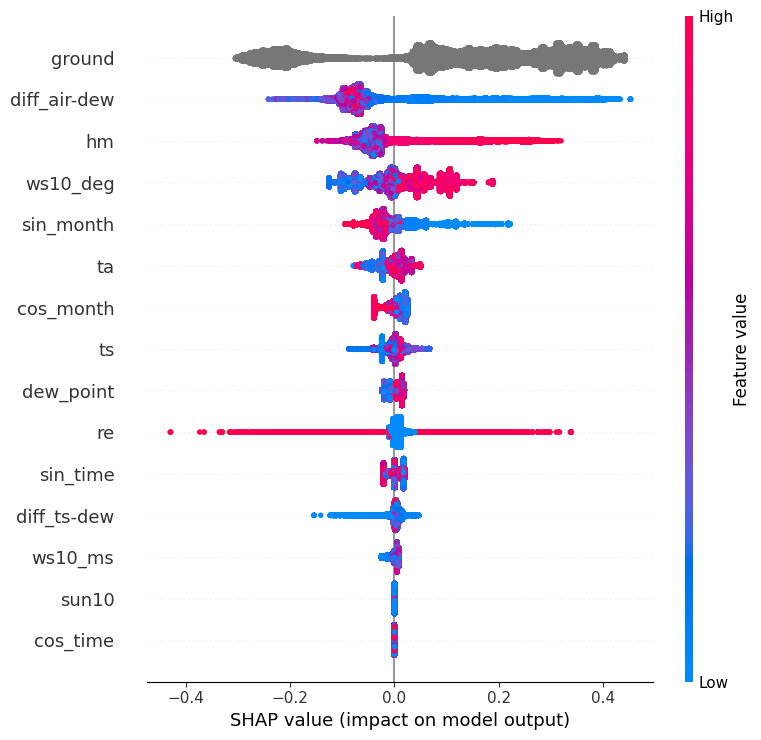

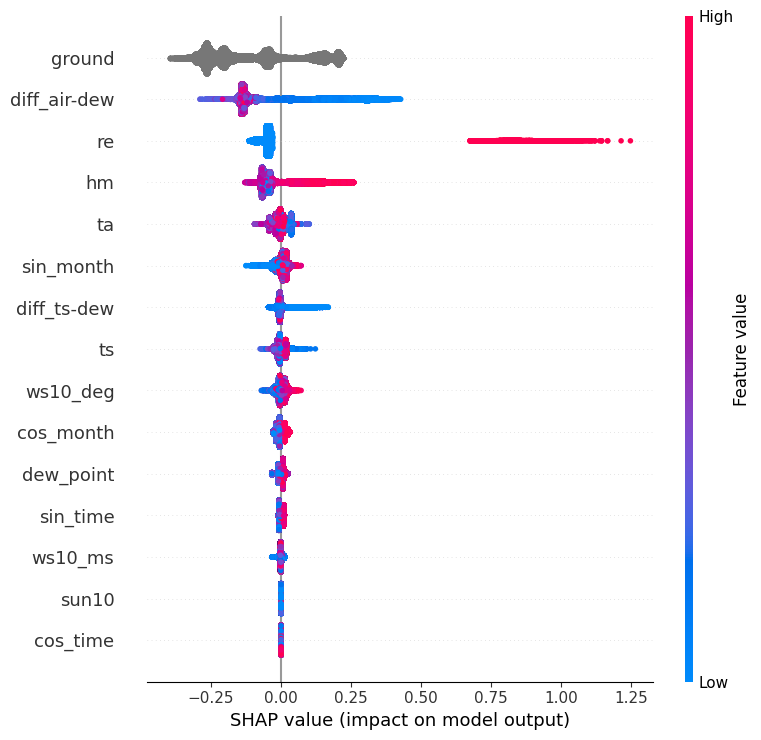

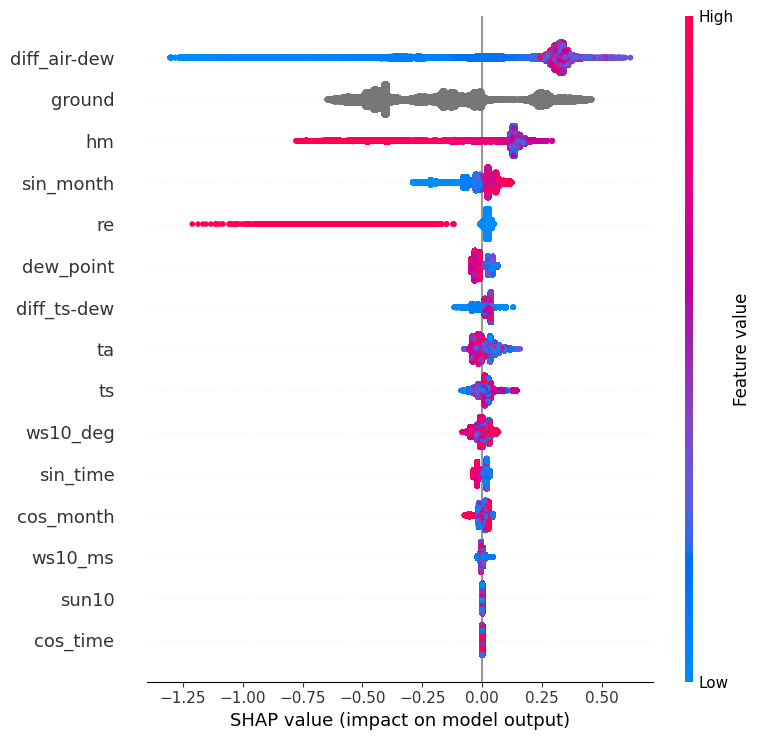

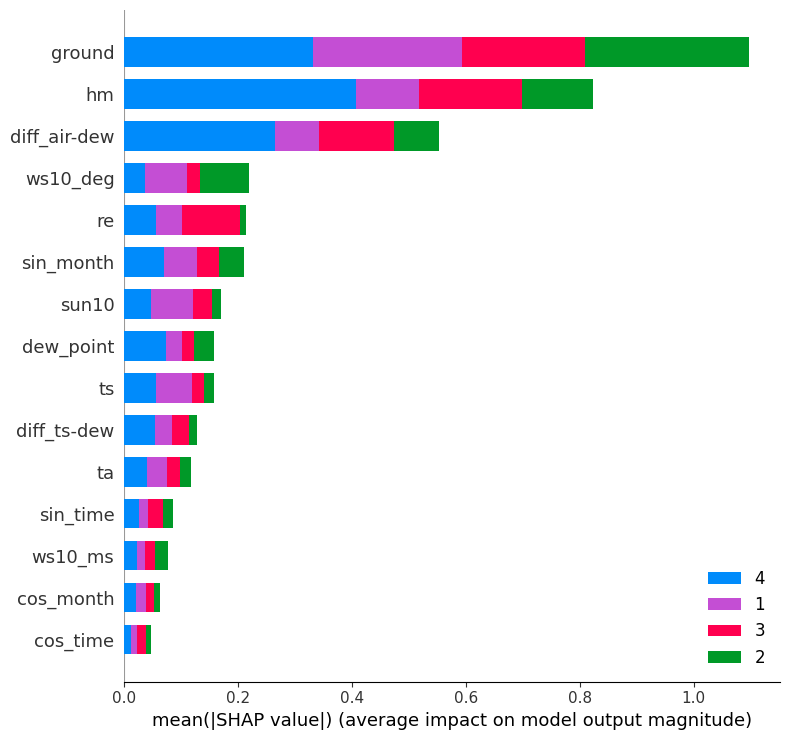

--------------------------------------------------------------------------------


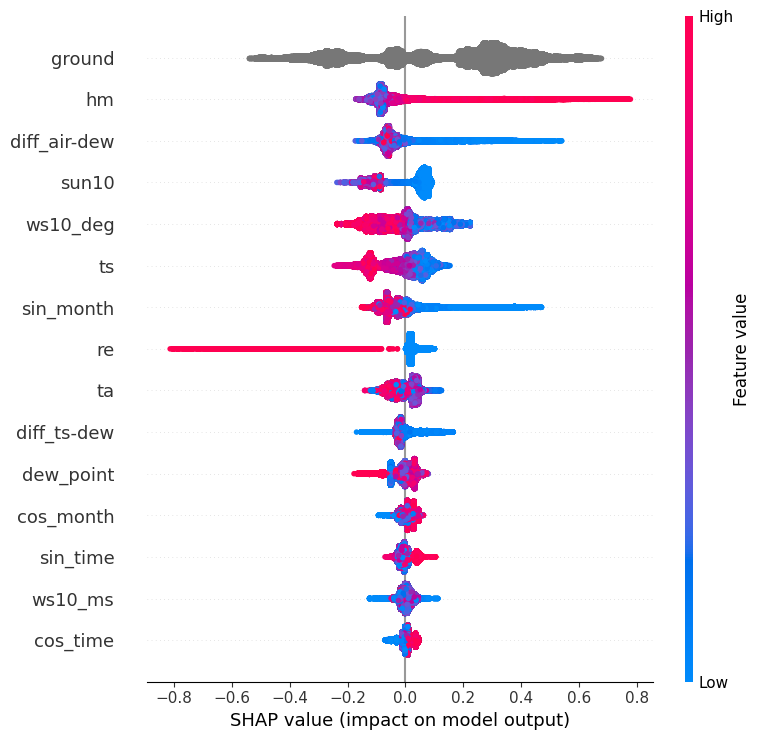

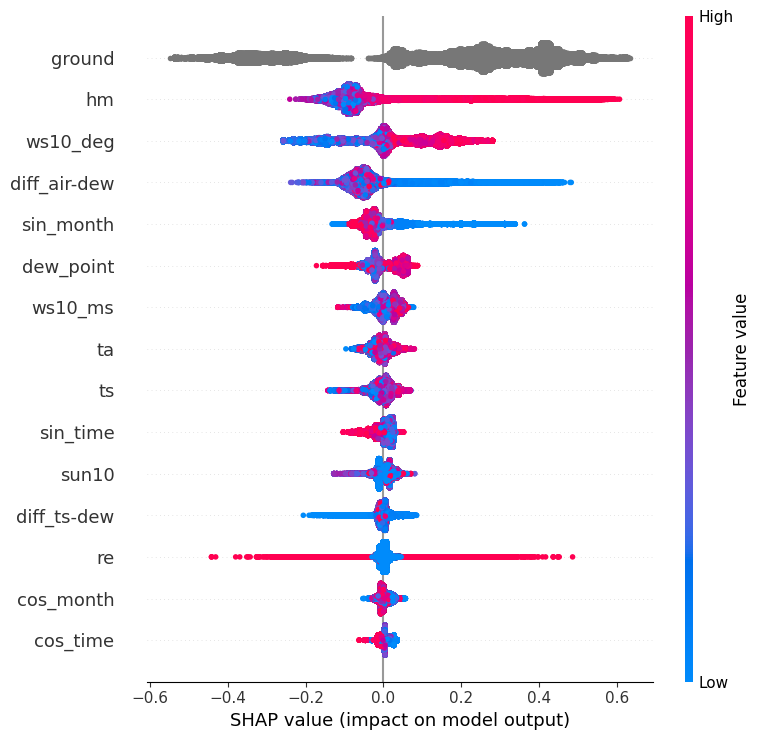

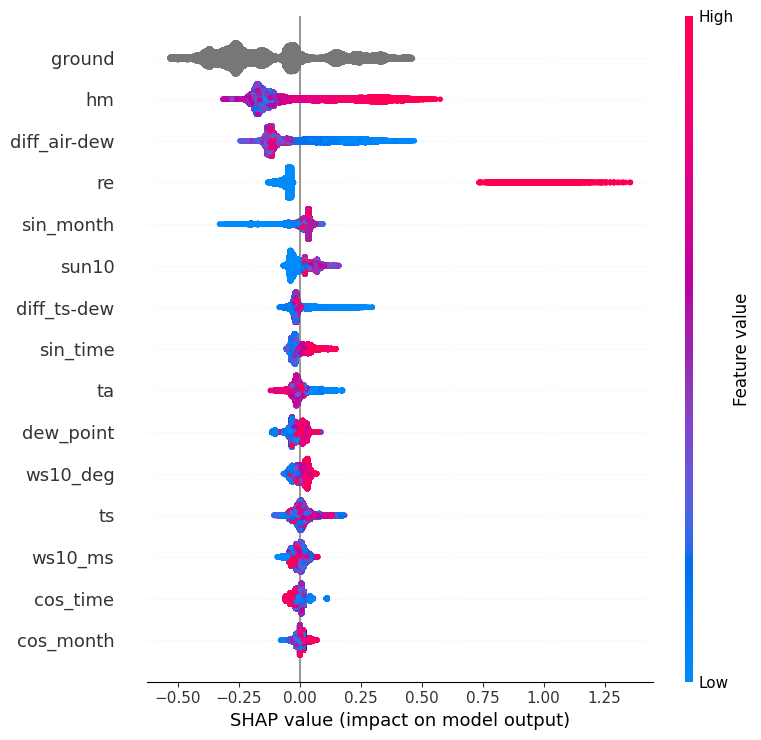

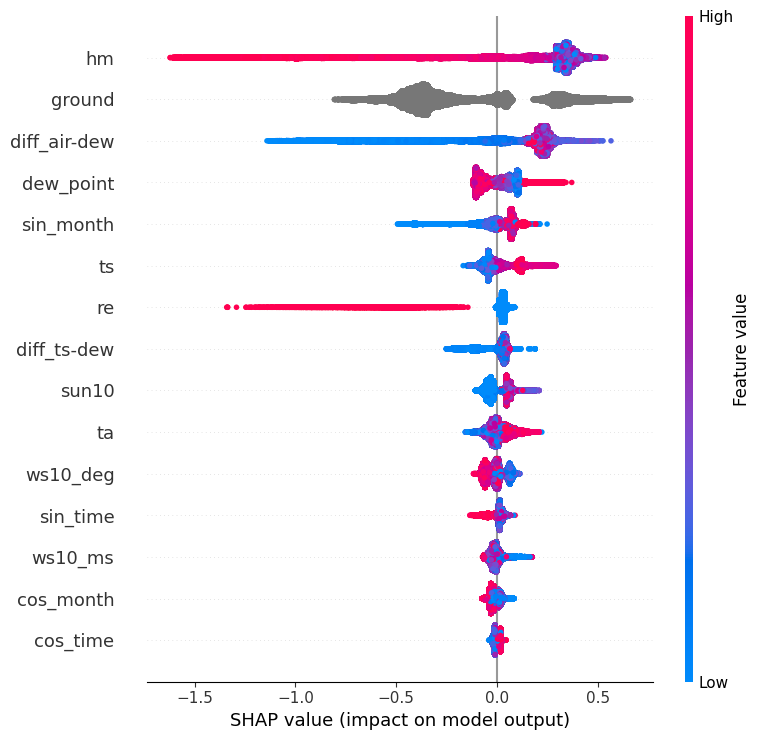

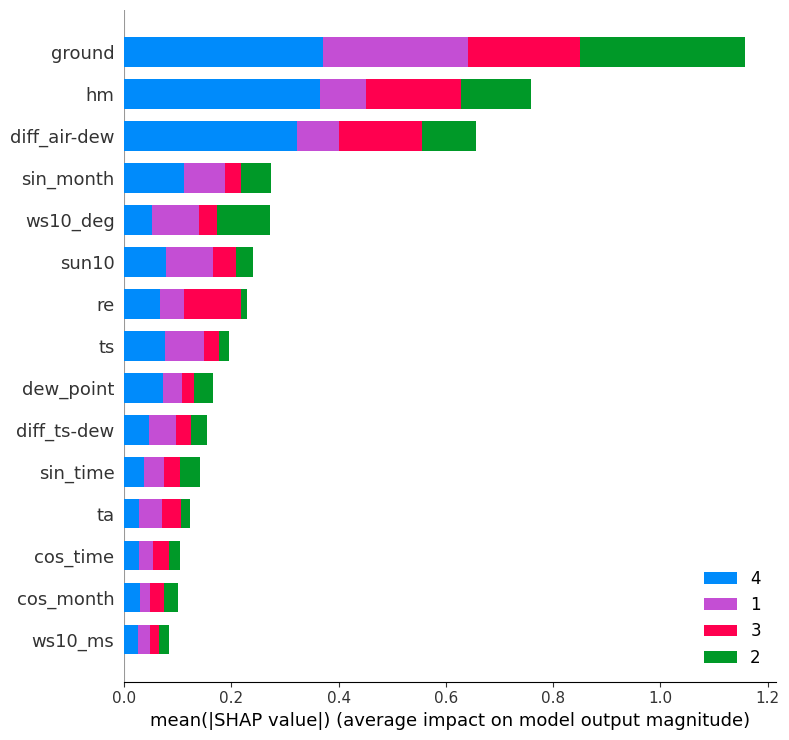

--------------------------------------------------------------------------------


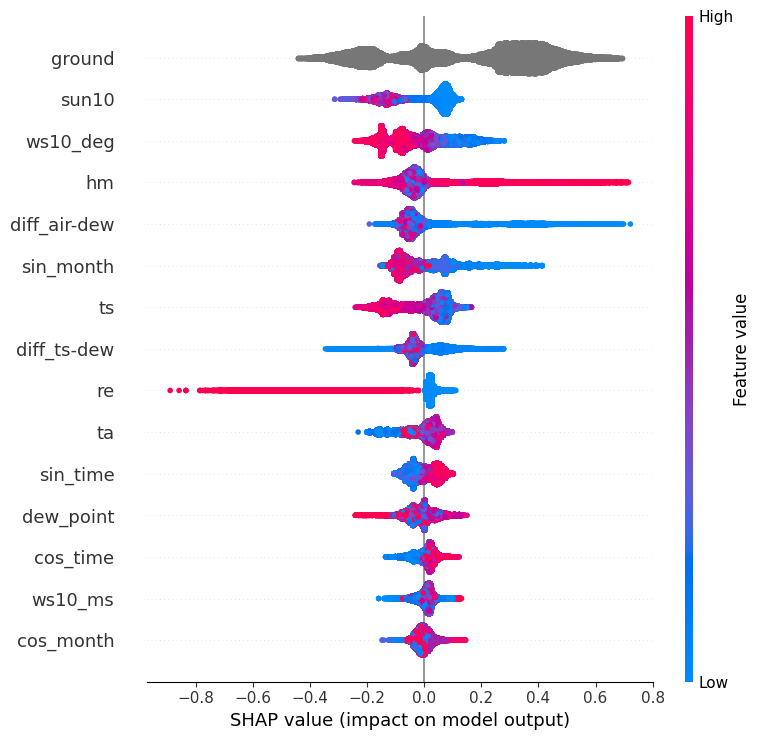

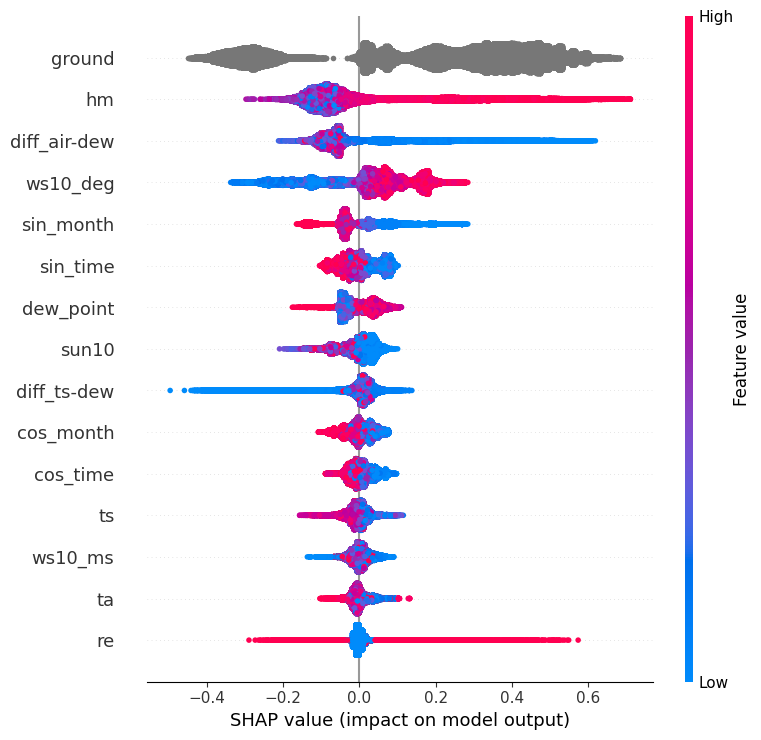

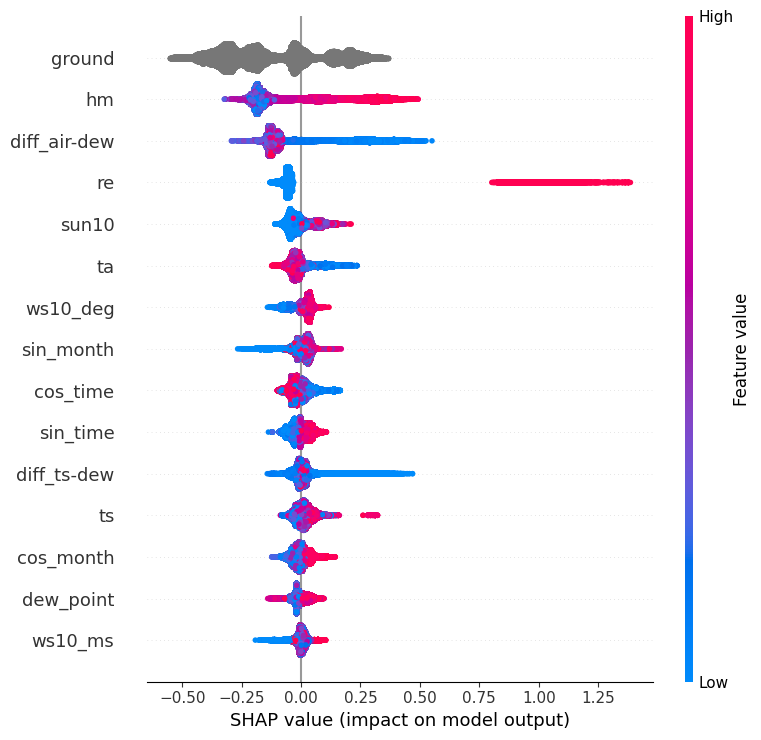

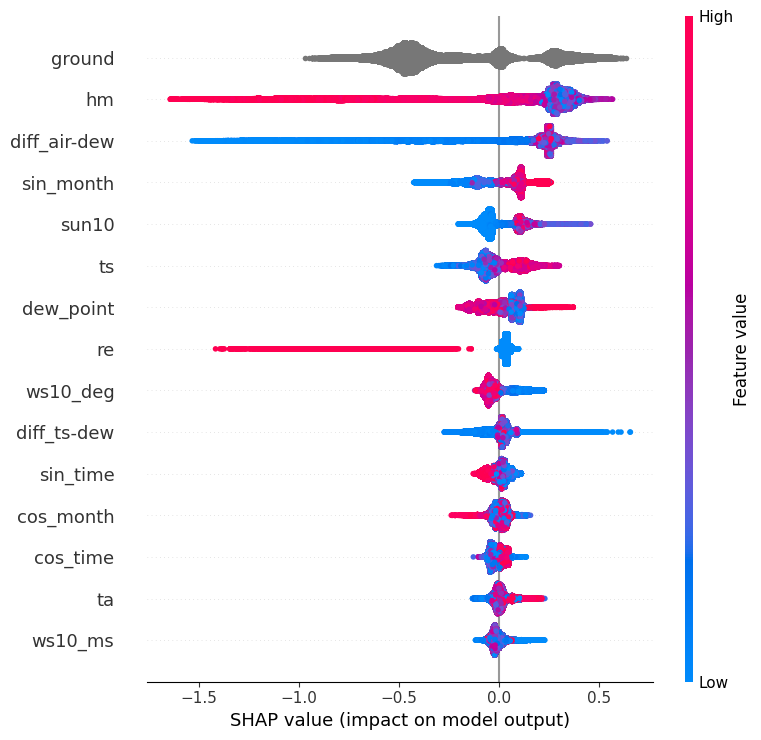

In [173]:
# 분석 결과 feature importance 확인
for model in models:
    print("=" * 80)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test_x)
    class_names = [1, 2, 3, 4]
    # feature importance plot
    shap.summary_plot(shap_values, train_x, plot_type="bar",
                  class_names= class_names, feature_names = train_x.columns)
    
    print("-" * 80)
    # visualize 
    shap.summary_plot(shap_values[0], test_x)
    shap.summary_plot(shap_values[1], test_x)
    shap.summary_plot(shap_values[2], test_x)
    shap.summary_plot(shap_values[3], test_x)